<a href="https://colab.research.google.com/github/razzkoirala/devops-camp-pipeline/blob/main/LabDocument/7_Automated_Security_Scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Security Scans

Updated: 5/5/2022


## Overview
In this lab, students will learn how to scan Docker images stored in Harbor for security vulnerabilities. 

**Estimated Time:** 30 min

Setup needed:
- Introduction to Harbor

## Learning Objectives

1. Manually Run a Harbor Scan

2. Automate Harbor Scanning

3. Understanding How to Fix Vulnerabilities

# Instructions

## Manually Run a Harbor Scan

1. In a browser, navigate to Harbor https://harbor.dev.afsmtddso.com/ and log in to your account

2. Click on your project

<figure>
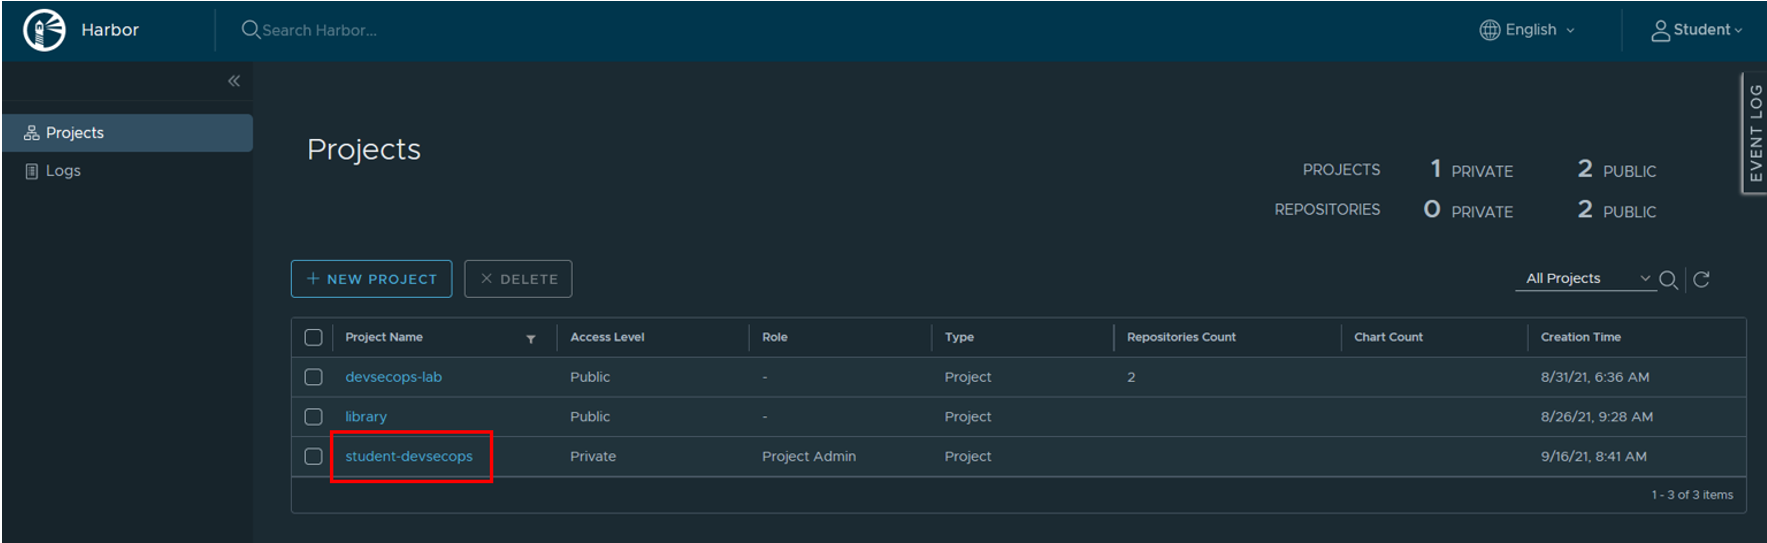
</figure>

3.	Select the repository with your application in it (it should be ```<your harbor project name>/app```)

<ul>
a. Once in the repository, click the checkmark next to your image; if you have multiple, check the most recent one at the top

b. Click the “Scan” button
</ul>

<figure>
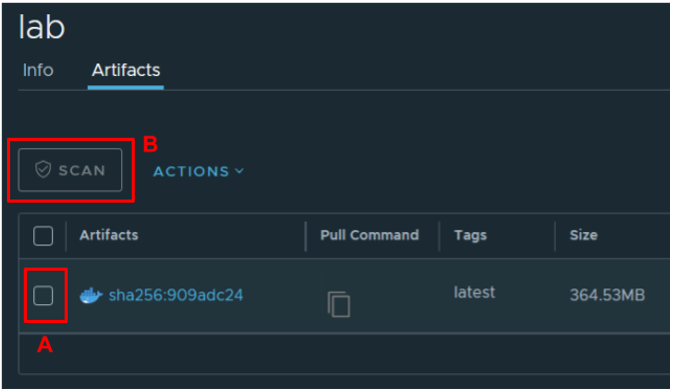
</figure>

4. You will see your scan be queued, then the scan will occur

5. Once the scan is complete, you should now see information in the “Vulnerabilities” tab

<figure>
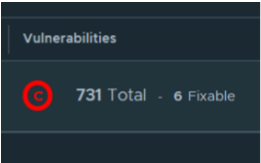
</figure>

6. Click on your image’s SHA link and scroll down to see a more detailed report of vulnerabilities

<figure>
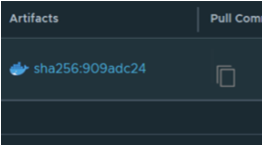
</figure>

7. Expand some of the vulnerabilities from the list to see a description of what each issue is

<figure>
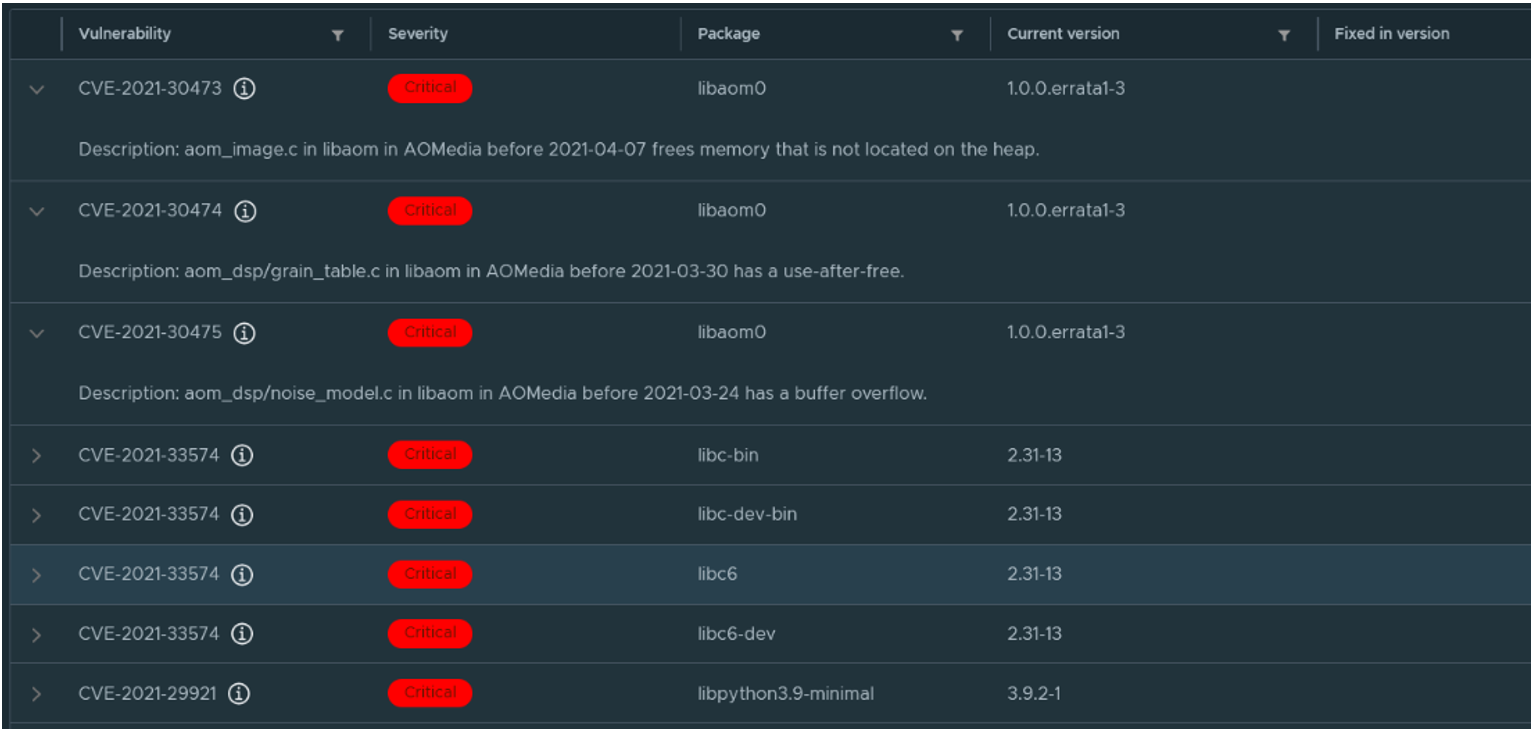
</figure>

## Automate Harbor Scanning

1. To automate the scanning process, your pipeline script will run a Python program. The Python program will utilize Harbor API endpoints to scan the Docker images via HTTP protocol.


<ul>
a. On the Harbor website, click on “Harbor API v2.0” on the bottom left to access the Swagger documentation
</ul>

<figure>
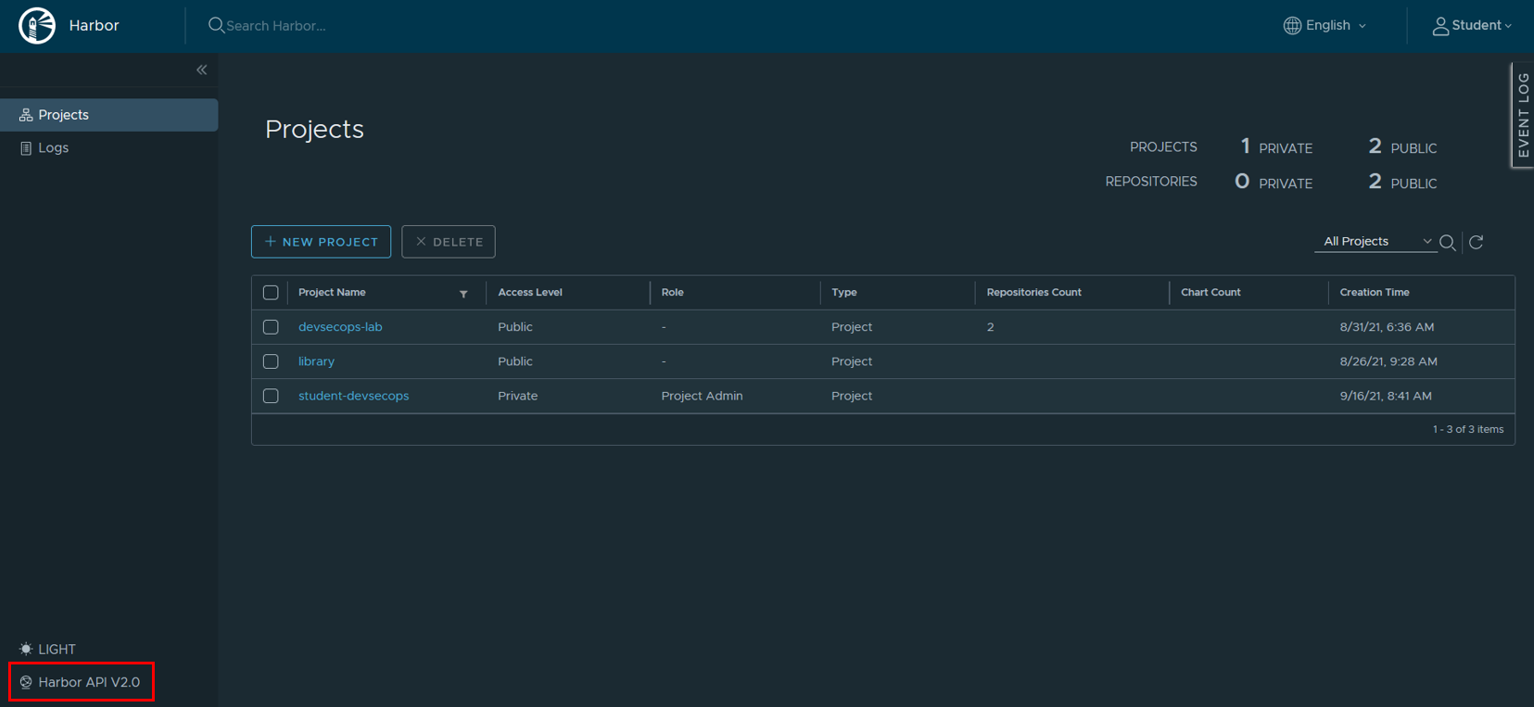
</figure>

2.	The Swagger documentation will provide you the base URL and a list of available URI endpoints to use for automation.

 > **Note:** The following steps 2a to 2c for the Swagger endpoints are for informational purposes.


<ul>

a. The base URL will be used in your Python program
</ul>

<figure>
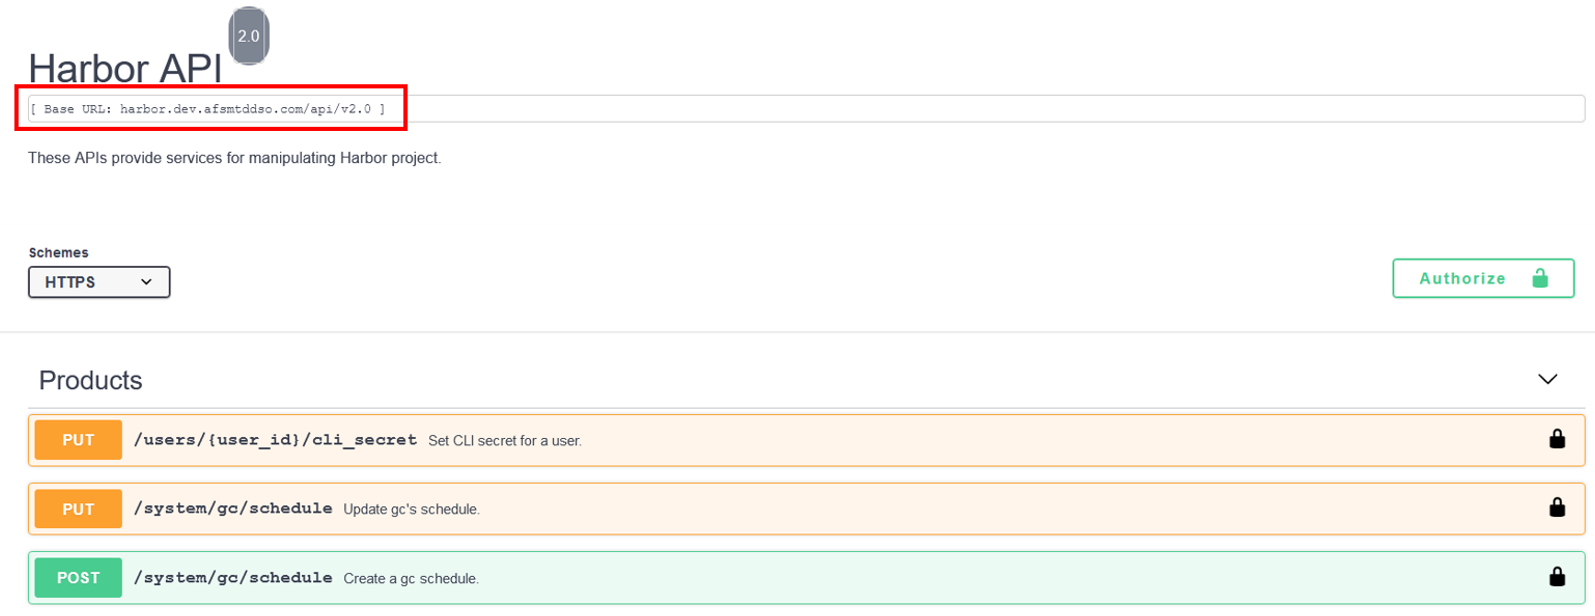
</figure>

<ul>
b. Scroll down to the “artifact” section
<ul>
i. Locate the URI to list artifacts

ii. This endpoint will list the images in your Harbor repository
</ul>
</ul>

<figure>
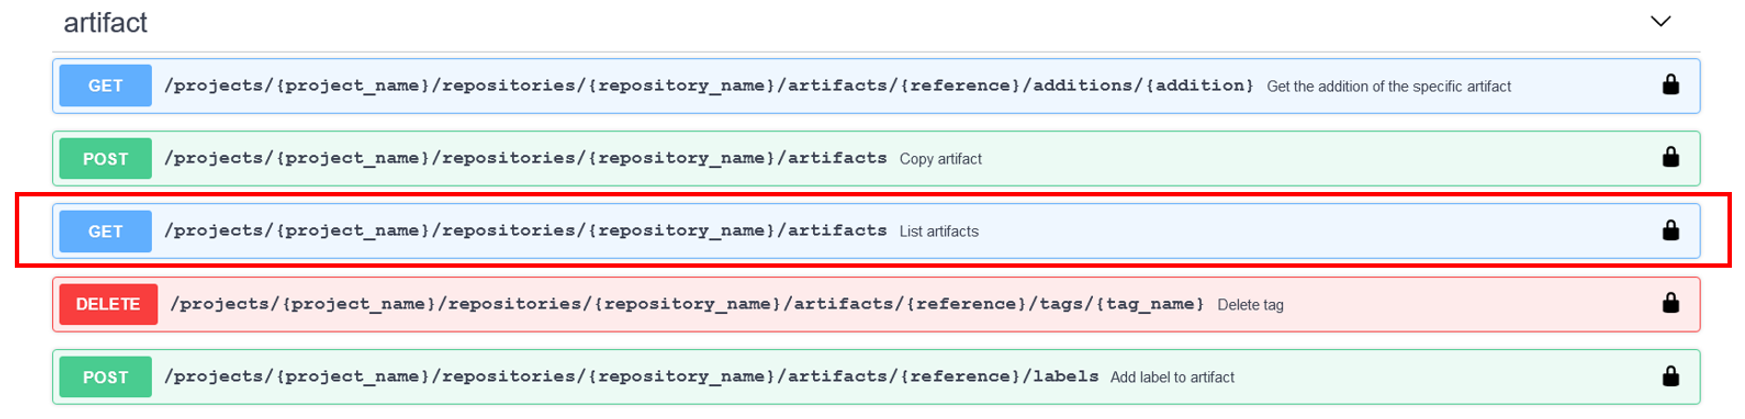
</figure>

<ul>
c. Scroll down to the “scan” section
<ul>
i. Locate the URI to scan an artifact

ii. This endpoint will start an image scan
</ul>
</ul>

<figure>
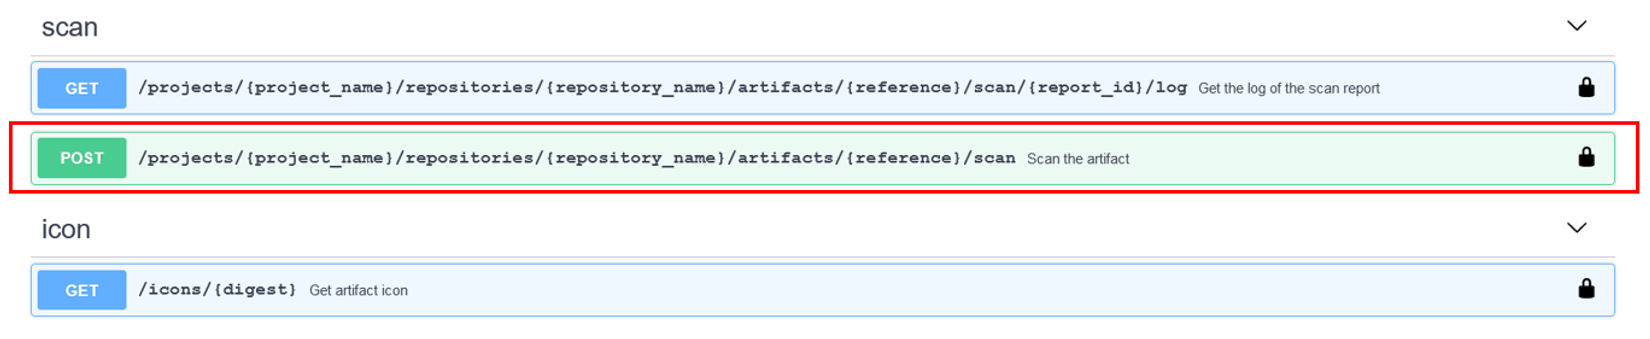
</figure>

<ul>

 > **Note:** Clicking on the URI endpoint will show useful information such as query parameters

</ul>

3. Download the Python script that will be used to scan your images by running the following command in your VSCode terminal, within your `devops-camp-pipeline` folder:

In [ ]:
curl -O 'https://raw.githubusercontent.com/khaledAFS/sample-files/main/post_security_scan_lab/harbor_scanner.py'

4. Please read the following explanations so that you can understand how the script automates the process of scanning your application and database images. 

  > _**IMPORTANT:**_ The following code snippets are in the script you just downloaded, so you don't have to copy and paste them again.

<ul>

a. We want to configure the script to accept arguments and flags (in this case, your Harbor project name, docker image, registry hostname, and credentials). Later on, we'll add a command to our Jenkinsfile that calls/runs this script along with the aforementioned arguments. 

</ul>

In [ ]:
import requests, time, sys, json, getopt

## Arguments needed from user ##
argList = sys.argv[1:]
options = 'c:i:p:r:'

arguments, values = getopt.getopt(argList, options)
for currentArgument, currentValue in arguments:
  if currentArgument in ("-c"):
    username, password = currentValue.split(':')
  elif currentArgument in ("-i"):
    imageName = currentValue
  elif currentArgument in ("-p"):
    projectName = currentValue
  elif currentArgument in ("-r"):
    registry = currentValue

<ul>

b. In the following section of the code, we are using the base URL and artifact URI to create a GET request to the Harbor scanner. The request will grab the artifact reference associated with your repository.

</ul>

In [ ]:
## Grab sha256 digest from Harbor project repository ##
urlArtifact = 'https://' + registry + '/api/v2.0/projects/' + projectName + '/repositories/' + imageName + '/artifacts/'
digestResp = requests.get(urlArtifact, auth=(username, password))
artifactReference = digestResp.json()[0]['digest']

<ul>

> **Note:** The artifact reference is a URI parameter to target a specific image resource. In the code snippet above, the SHA256 digest will be used as the artifact reference.

</ul>

<ul>

c. Next, we are making a POST request to scan the docker image and checking to ensure the scan completes successfully

</ul>

In [ ]:
## Initialize image scanner ##
urlScanInit = urlArtifact + artifactReference + '/scan'
scanInitResp = requests.post(urlScanInit, data={}, auth=(username, password))
if scanInitResp.status_code != 202:
  print('Failed to scan image')
  print('Server response code:', scanInitResp.status_code)
  sys.exit(-1)

<ul>

> **Note:** Use exit codes to control your pipeline when something goes wrong. An exit code of -1 will fail the scanning stage of your pipeline.

</ul>

<ul>

d. Then, we are parsing the JSON results from the scan request to display relevant information about project vulnerabilities

</ul>

In [ ]:
## Checks scanner status ##
urlScanOverview = urlArtifact + artifactReference + '?with_scan_overview=true'
scanStatus = 'Pending'
maxApiCall = 5

while scanStatus != 'Success':
  scanOverviewResp = requests.get(urlScanOverview, auth=(username, password))
  scanOverviewResult = scanOverviewResp.json()['scan_overview']['application/vnd.scanner.adapter.vuln.report.harbor+json; version=1.0']
  scanStatus = scanOverviewResult['scan_status']
  print(scanStatus)
  if scanStatus == 'Success':
    break
  elif maxApiCall <= 0:
    print('Reached maximum API calls')
    sys.exit(-1)
  else:
    maxApiCall -= 1
    time.sleep(4)

print(json.dumps(scanOverviewResult['summary'], indent=4))

<ul>

> **Note:** The `?with_scan_overview=true` query parameter will provide information on the status and summary of the scan.

</ul>

5. After adding your automation script to the `devops-camp-pipeline` directory, we need to add a "Security scanning" stage in `devops-camp-jenkinsfile` _after_ the `stage('Application docker build') {}` block to scan the Docker images.

In [ ]:
stage('Security scanning') {
            steps {
                  withCredentials([usernamePassword(credentialsId: '<YOUR HARBOR CREDENTIAL ID>', usernameVariable: 'USERNAME', passwordVariable: 'PASSWORD')]) {
                      echo "Scanning $APP_IMAGE_NAME image"
                      sh 'python harbor_scanner.py -i $APP_IMAGE_NAME -r $HARBOR_REGISTRY -p $HARBOR_PROJECT -c ${USERNAME}:${PASSWORD}'
                  }
            }
        }

<ul>

> **Note:** Notice how the lines that begin with `sh` use the format explained in step 4a.

> **Tip:** _Replace_ `<YOUR HARBOR CREDENTIAL ID>` with your your credentials for Harbor (should be `<first initial + last name>-harbor-auth`) so that the pipeline has authorization to scan your Docker images.

a. Add the same code snippet to your `devops-camp-db-jenkinsfile`, _after_ the `stage('Database docker build') {}` block. _Replace_ all instances of `$APP_IMAGE_NAME` to `$DB_IMAGE_NAME`

</ul>

6. Make sure you're in the right directory in the terminal before adding, committing and pushing your changes to GitHub

  a. `git add .`

  b. `git commit -m "adding harbor scan file"`

  c. `git push`


## You're done if...

1. Your application pipeline builds successfully; i.e., all the stages are green

2. Verify that your Python script completed the scan

<ul>

a. Check the status of your application pipeline by clicking on the most recent build in the “Build History” section on the bottom left
</ul>

<figure>
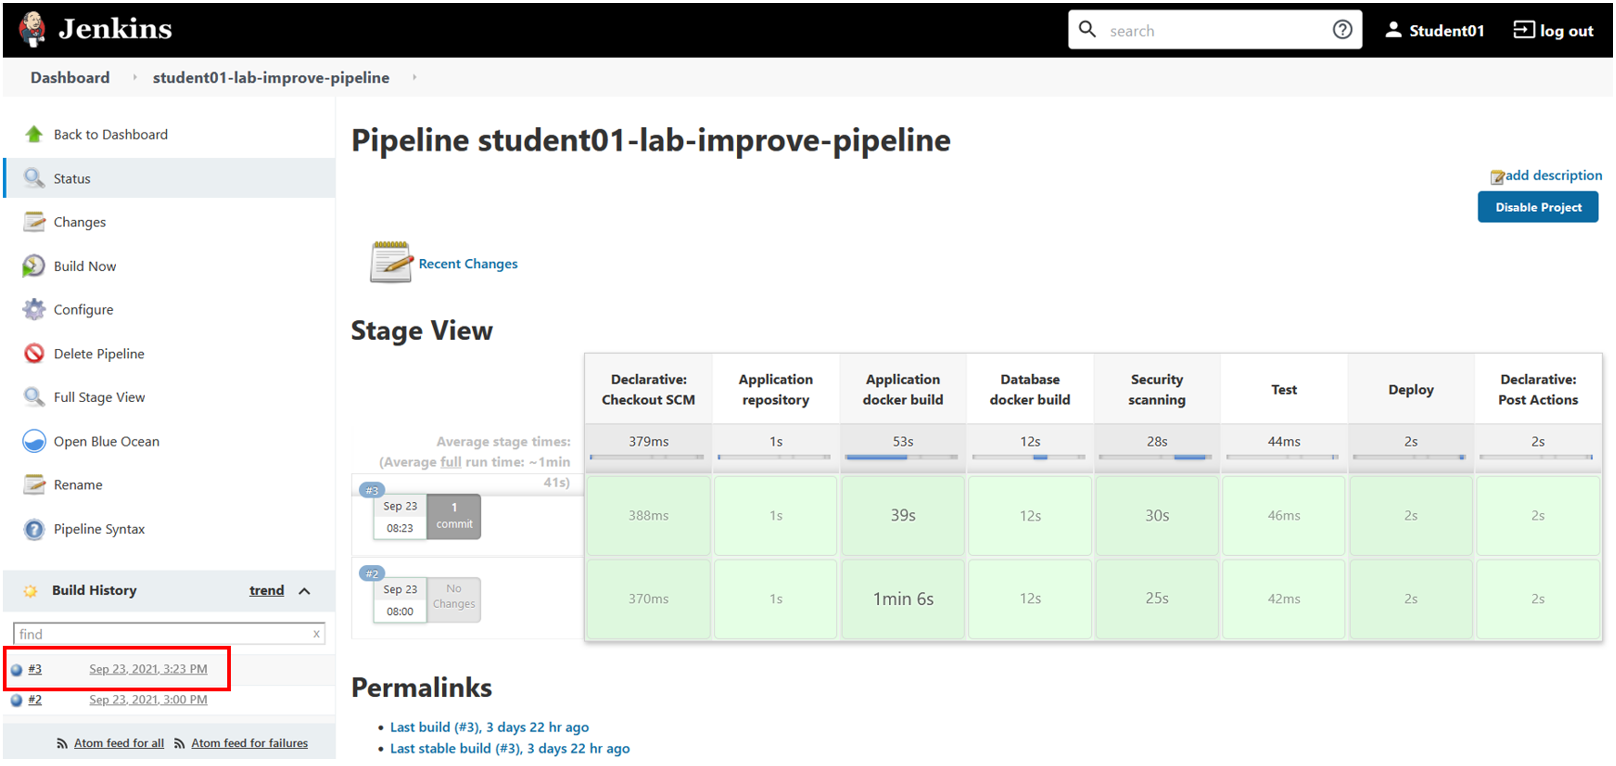
</figure>

<ul>
b. Click on “Console Output” to view the output
</ul>

<figure>
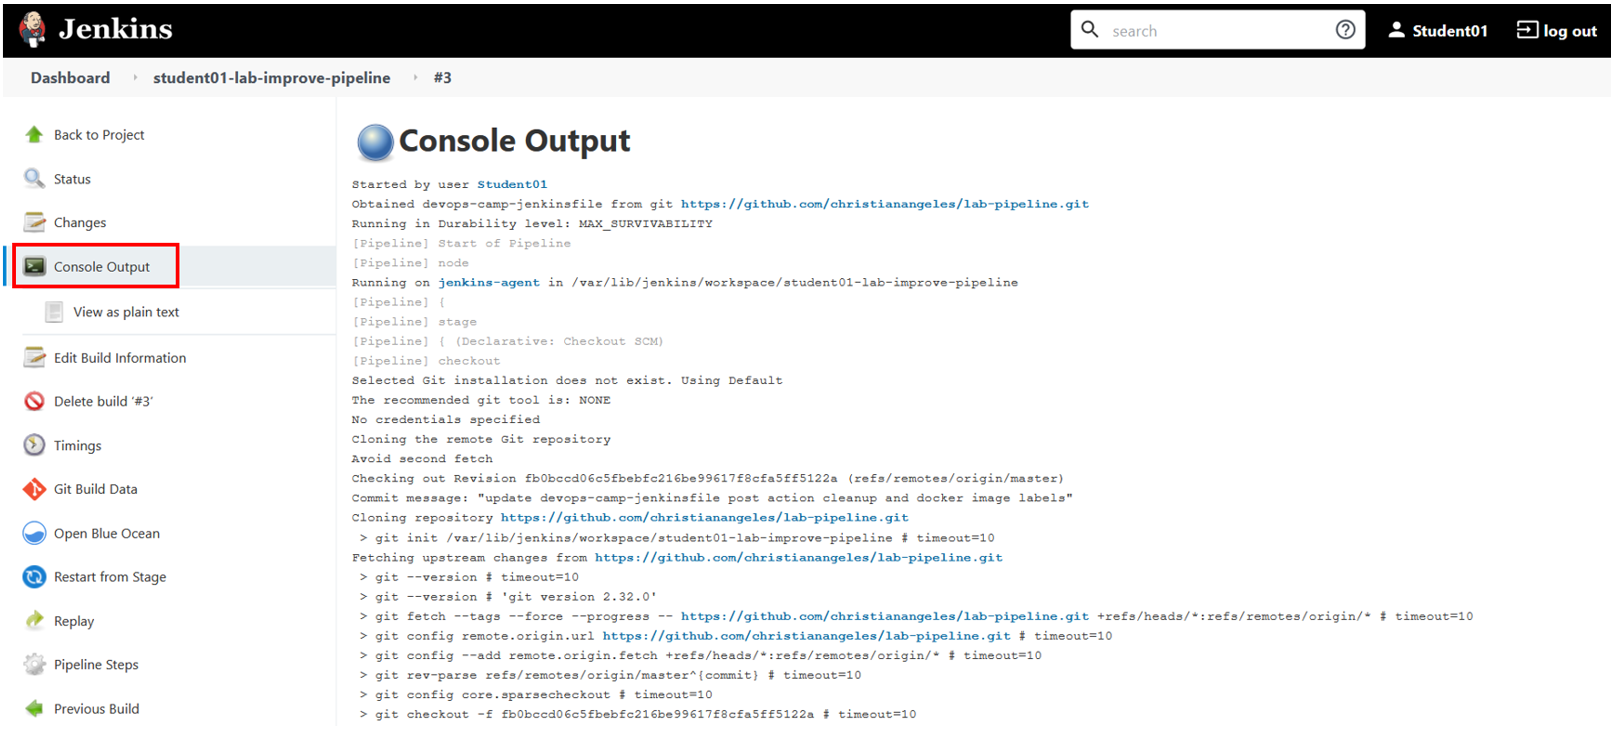
</figure>

<ul>
c. Verify the summary of your image scan in the “Console Output” by holding down Ctrl+F and searching for "harbor_scanner.py":
</ul>

<figure>
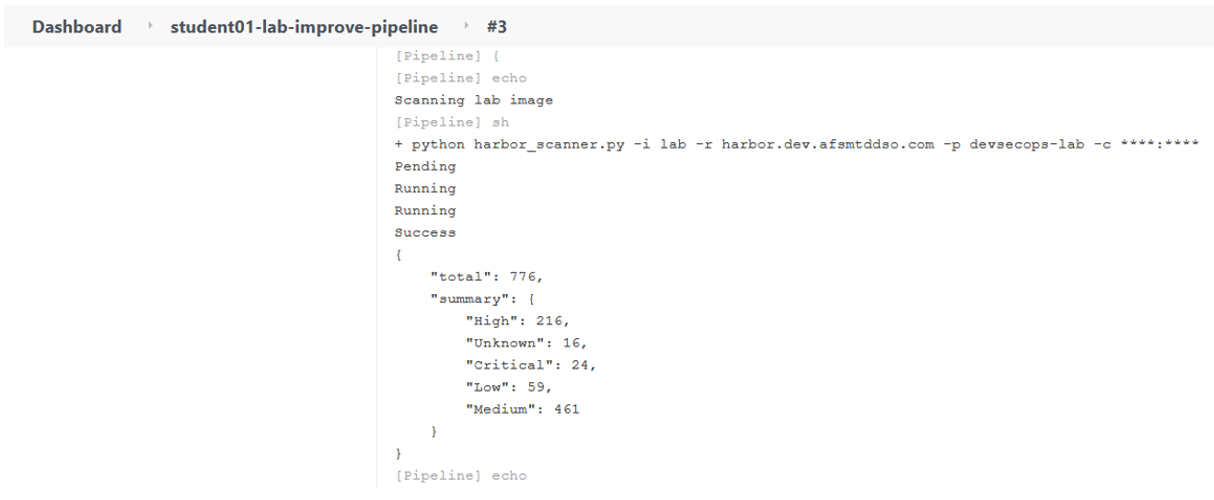
</figure>

<ul>

> **Note:** You'll have to make a change to `/afs-labs-student/database/database.sql` to see the scan's output in your DB pipeline.

</ul>

## Understanding How to Fix Vulnerabilities

1. Choose any of your images in Harbor and look through the list of vulnerabilities produced by a scan

 > **Note:** You can find the steps for this in Section 1 of this handout

2. Do some research to determine what some of the issues are and how they would be addressed.
 - Pay attention to the dependencies that are a part of your image&#8212;why are vulnerabilities coming from there rather than from the code you wrote?


# Appendix

Sample files of what your files should look like after this lab are available at:  https://github.com/khaledAFS/sample-files/tree/main/post_security_scan_lab
